### **Load libraries and data**

In [2]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip --version

pip 25.1.1 from /Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/pip (python 3.10)


In [3]:
# Installation of necessary libraries
import sys

# Install required libraries
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install lifelines
!{sys.executable} -m pip install gseapy
!{sys.executable} -m pip install scikit-learn==1.5.2
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install umap-learn
!{sys.executable} -m pip install scikit-survival

  Using cached scikit_learn-1.5.2-cp310-cp310-macosx_12_0_arm64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-macosx_12_0_arm64.whl (11.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-survival 0.24.1 requires scikit-learn<1.7,>=1.6.1, but you have scikit-learn 1.5.2 which is incompatible.
  Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (31 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


In [172]:
# import libraries to use
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import datasets, model_selection, metrics
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import umap
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, RocCurveDisplay, precision_score, accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import StratifiedKFold,cross_val_score, cross_val_predict
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.inspection import permutation_importance
from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sklearn.inspection import permutation_importance

### **Data formatting and processing**

We have 3 tables with data: clinical data, sequencing results for glioma patients and table with some genes clustered into molecultar pathways. We will start with primary description of the patiens cohort from the clinical data, then look at the sequencing results (only keeping missence or nonsence mutations for simplicity), and assign genes to pathways.

In [173]:
# Read the data into dataframes
data_mutations_short = pd.read_csv('data_mutations_short.csv', sep=",")
clinical_data = pd.read_csv('lgggbm_tcga_pub_clinical_data_short.csv', sep=",")
pathways = pd.read_csv('pathways.csv')

In [174]:
# show df
data_mutations_short

,Hugo_Symbol,Variant_Classification,Tumor_Sample_Barcode
0,AKAP6,Missense_Mutation,TCGA-02-0003
1,ANAPC4,Missense_Mutation,TCGA-02-0003
2,AUTS2,Missense_Mutation,TCGA-02-0003
3,ABTB3,Missense_Mutation,TCGA-02-0003
4,CLEC3B,Silent,TCGA-02-0003
...,...,...,...
30724,FLNC,Frame_Shift_Del,TCGA-WY-A85E
30725,MT-ND5,Silent,TCGA-CS-4943
30726,MT-CO1,Silent,TCGA-DH-5141
30727,MT-CO1,Missense_Mutation,TCGA-CS-4943


In [175]:
# show df
pathways

,"Pathway,Genes"
0,"Astrocytic drivers,""ATRX, TP53, IDH1, IDH2"""
1,"Cell-cycle control,""CCND2, CDK4, CDK6, CDKN1A,..."
2,"Chromatin remodeling,""ARID1A, ARID1B, ARID2, A..."
3,"Histone methylation,""KMT2A, KMT2C, KMT2D, SETD..."
4,"MYC/MAX signaling,""FBXW7, MAX, MYC, MYCN, MLX,..."
5,"NOTCH pathway,""NOTCH1, NOTCH2, DLL1, DLL3, JAG..."
6,"Oligodendroglial drivers,""CIC, FUBP1, IDH1"""
7,"p53 signaling,""MDM2, MDM4, TP53, ATM, CHEK2, BAX"""
8,"PI3K/AKT,""AKT1, AKT2, AKT3, MTOR, PIK3CA, PIK3..."
9,"RTK-RAS,""BRAF, EGFR, HRAS, KDR, KRAS, MET, NF1..."


In [177]:
# show df
clinical_data

,Patient ID,Sample ID,Absolute Extract Ploidy,Diagnosis Age,ATRX status,BCR Status,BRAF-KIAA1549 fusion,BRAF V600E status,Cancer Type,Cancer Type Detailed,...,Percent aneuploidy,Sex,Study,Telomere length estimate in blood normal (Kb),Telomere length estimate in tumor (Kb),Telomere Maintenance,TERT expression (log2),TERT expression status,TERT promoter status,TMB (nonsynonymous)
0,TCGA-02-0001,TCGA-02-0001-01,3.47,44,NaN,IGC,NaN,NaN,Glioma,Diffuse Glioma,...,0.424900,Female,Glioblastoma multiforme,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-02-0003,TCGA-02-0003-01,1.96,50,WT,IGC,NaN,WT,Glioma,Diffuse Glioma,...,0.147988,Male,Glioblastoma multiforme,NaN,NaN,NaN,NaN,NaN,NaN,1.366667
2,TCGA-02-0004,TCGA-02-0004-01,NaN,59,NaN,IGC,NaN,NaN,Glioma,Diffuse Glioma,...,0.117881,Male,Glioblastoma multiforme,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TCGA-02-0006,TCGA-02-0006-01,1.93,56,NaN,IGC,NaN,NaN,Glioma,Diffuse Glioma,...,0.239055,Female,Glioblastoma multiforme,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TCGA-02-0007,TCGA-02-0007-01,1.89,40,NaN,IGC,NaN,NaN,Glioma,Diffuse Glioma,...,0.257454,Female,Glioblastoma multiforme,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,TCGA-VW-A7QS,TCGA-VW-A7QS-01,1.95,35,WT,NCH,WT,WT,Glioma,Diffuse Glioma,...,0.086236,Female,Brain Lower Grade Glioma,NaN,NaN,NaN,4.754888,Expressed,NaN,0.933333
1043,TCGA-VW-A8FI,TCGA-VW-A8FI-01,NaN,66,WT,NCH,WT,WT,Glioma,Diffuse Glioma,...,0.107533,Male,Brain Lower Grade Glioma,NaN,NaN,NaN,6.643856,Expressed,NaN,1.233333
1044,TCGA-W9-A837,TCGA-W9-A837-01,NaN,47,WT,NCH,WT,WT,Glioma,Diffuse Glioma,...,0.062593,Male,Brain Lower Grade Glioma,NaN,NaN,NaN,3.169925,Expressed,NaN,0.600000
1045,TCGA-WH-A86K,TCGA-WH-A86K-01,NaN,65,WT,NCH,WT,WT,Glioma,Diffuse Glioma,...,0.161448,Male,Brain Lower Grade Glioma,NaN,NaN,NaN,0.000000,Not expressed,NaN,0.933333


In [178]:
# Step 1: Split the 'Pathway,Genes' column into 'Pathway' and 'Genes' based on the first comma
pathways[['Pathway', 'Genes']] = pathways['Pathway,Genes'].str.split(',', n=1, expand=True)

# Step 2: Remove the original 'Pathway,Genes' column (not needed anymore)
pathways.drop(columns=['Pathway,Genes'], inplace=True)

# Step 3: Remove quotes and split the 'Genes' into individual gene names
pathways['Genes'] = pathways['Genes'].str.replace('"', '').str.split(', ')

# Step 4: Explode the 'Genes' column so that each gene gets its own row
pathways_exploded = pathways.explode('Genes').reset_index(drop=True)

# Step 5: Clean up any leading/trailing spaces and convert gene names to uppercase
pathways_exploded['Genes'] = pathways_exploded['Genes'].str.strip().str.upper()

# Step 6: Show the cleaned and exploded pathways DataFrame
pathways_exploded

,Pathway,Genes
0,Astrocytic drivers,ATRX
1,Astrocytic drivers,TP53
2,Astrocytic drivers,IDH1
3,Astrocytic drivers,IDH2
4,Cell-cycle control,CCND2
...,...,...
90,Telomere maintenance,POT1
91,Telomere maintenance,DKC
92,Telomere maintenance,ACD
93,Telomere maintenance,TINF2


In [179]:
# Standardize formatting by stripping whitespace and converting to uppercase
data_mutations_short['Tumor_Sample_Barcode'] = data_mutations_short['Tumor_Sample_Barcode'].str.strip().str.upper()
clinical_data['Sample ID'] = clinical_data['Sample ID'].str.strip().str.upper()
clinical_data['Patient ID'] = clinical_data['Patient ID'].str.strip().str.upper()

### **Primary description of the dataset**

Total Patient Count: 1047

Sex Distribution:
Sex
Male      618
Female    429
Name: count, dtype: int64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/3328182810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sex_distribution.index, y=sex_distribution.values, palette='pastel')


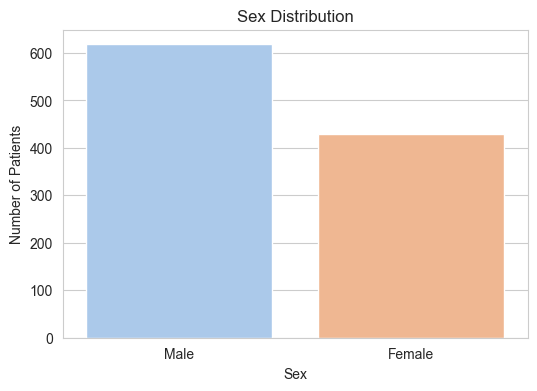

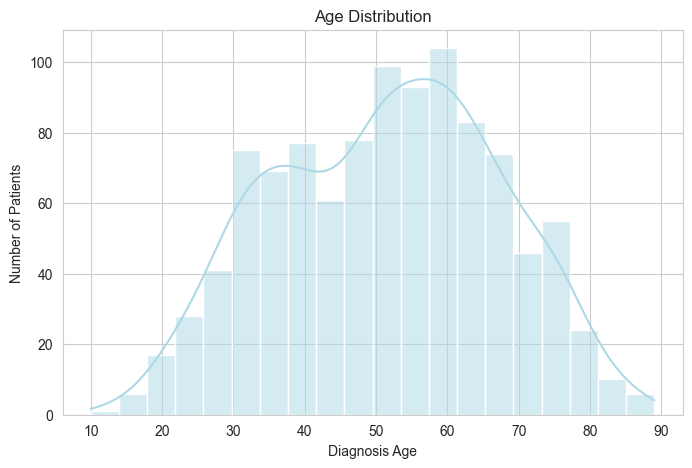


Neoplasm Histologic Type Distribution:
Neoplasm Histologic Type Name
glioblastoma         590
oligodendroglioma    174
astrocytoma          169
oligoastrocytoma     114
Name: count, dtype: int64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/3328182810.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=histologic_type_distribution.index, y=histologic_type_distribution.values, palette='muted')


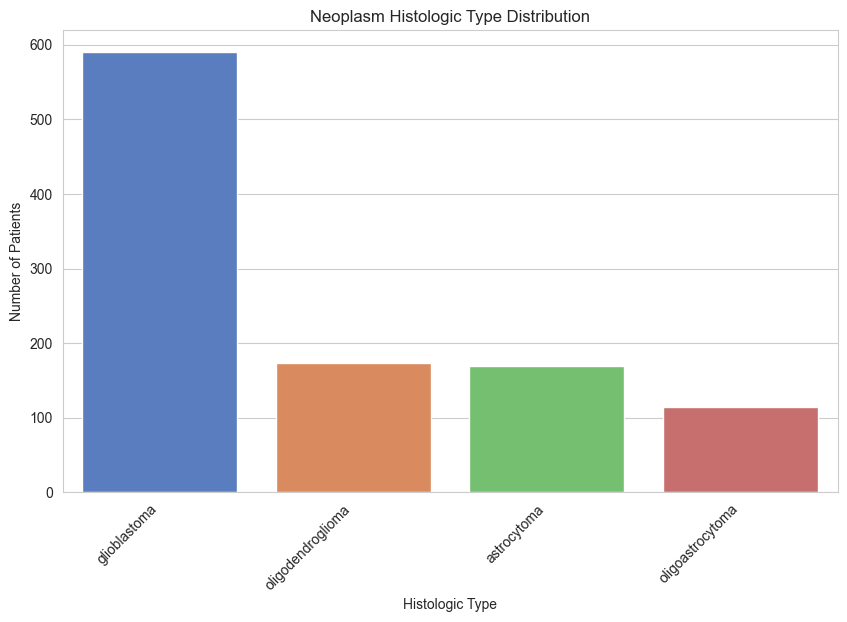


Neoplasm Histologic Grade Distribution:
Neoplasm Histologic Grade
G4    590
G3    241
G2    216
Name: count, dtype: int64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/3328182810.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=histologic_grade_distribution.index, y=histologic_grade_distribution.values, palette='deep')


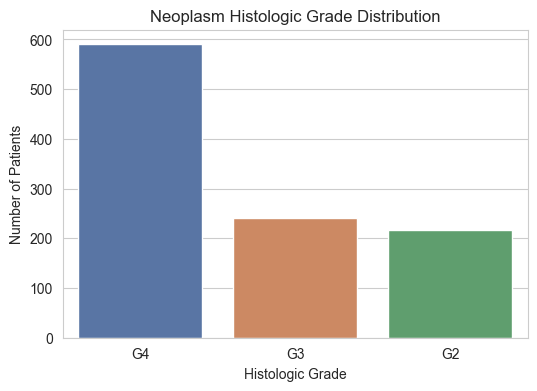

In [180]:
# Display total patient count
total_patients = clinical_data['Patient ID'].nunique()
print(f"Total Patient Count: {total_patients}")

# Plot and display Sex distribution
sex_distribution = clinical_data['Sex'].value_counts()
print("\nSex Distribution:")
print(sex_distribution)

plt.figure(figsize=(6, 4))
sns.barplot(x=sex_distribution.index, y=sex_distribution.values, palette='pastel')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Number of Patients')
plt.show()

# Plot and display Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(clinical_data['Diagnosis Age'], bins=20, kde=True, color='lightblue')
plt.title('Age Distribution')
plt.xlabel('Diagnosis Age')
plt.ylabel('Number of Patients')
plt.show()

# Display Neoplasm Histologic Type distribution
histologic_type_distribution = clinical_data['Neoplasm Histologic Type Name'].value_counts()
print("\nNeoplasm Histologic Type Distribution:")
print(histologic_type_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x=histologic_type_distribution.index, y=histologic_type_distribution.values, palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title('Neoplasm Histologic Type Distribution')
plt.xlabel('Histologic Type')
plt.ylabel('Number of Patients')
plt.show()

# Display Neoplasm Histologic Grade distribution
histologic_grade_distribution = clinical_data['Neoplasm Histologic Grade'].value_counts()
print("\nNeoplasm Histologic Grade Distribution:")
print(histologic_grade_distribution)

plt.figure(figsize=(6, 4))
sns.barplot(x=histologic_grade_distribution.index, y=histologic_grade_distribution.values, palette='deep')
plt.title('Neoplasm Histologic Grade Distribution')
plt.xlabel('Histologic Grade')
plt.ylabel('Number of Patients')
plt.show()

### **Merging clinical data table with mutated genes table**

Creating mutations_merged_df

In [181]:
# Step 1: Perform the merging steps to create the intermediate columns
merged_df = pd.merge(data_mutations_short, clinical_data[['Patient ID', 'Sample ID']],
                     left_on='Tumor_Sample_Barcode', right_on='Sample ID', how='left')

merged_df = pd.merge(merged_df, clinical_data[['Patient ID', 'Sample ID']],
                     left_on='Tumor_Sample_Barcode', right_on='Patient ID', how='left',
                     suffixes=('_from_sample', '_from_patient'))

# Step 2: Place this code here to finalize columns, rename, and calculate row counts

# Save the initial row count before dropping NaN values
initial_row_count = merged_df.shape[0]

# Finalize Patient ID and Sample ID columns based on available matches
merged_df['Patient ID'] = merged_df['Patient ID_from_sample'].combine_first(merged_df['Patient ID_from_patient'])
merged_df['Sample ID'] = merged_df['Sample ID_from_sample'].combine_first(merged_df['Sample ID_from_patient'])

# Drop rows with NaN values in the final Patient ID and Sample ID columns
merged_df = merged_df.dropna(subset=['Patient ID', 'Sample ID'])

# Save the row count after dropping NaN values
final_row_count = merged_df.shape[0]

# Drop intermediate columns used for matching
mutations_merged_df = merged_df.drop(columns=['Patient ID_from_sample', 'Patient ID_from_patient',
                                    'Sample ID_from_sample', 'Sample ID_from_patient'])

# Display the result for verification
print(f"Initial row count before dropping NaN: {initial_row_count}")
print(f"Final row count after dropping NaN: {final_row_count}")

print("Columns in the merged DataFrame:")
print(mutations_merged_df.columns)
print("First few rows of the merged DataFrame:")
print(mutations_merged_df.head())


Initial row count before dropping NaN: 30729
Final row count after dropping NaN: 28613
Columns in the merged DataFrame:
Index(['Hugo_Symbol', 'Variant_Classification', 'Tumor_Sample_Barcode',
       'Patient ID', 'Sample ID'],
      dtype='object')
First few rows of the merged DataFrame:
  Hugo_Symbol Variant_Classification Tumor_Sample_Barcode    Patient ID  \
0       AKAP6      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
1      ANAPC4      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
2       AUTS2      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
3       ABTB3      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
4      CLEC3B                 Silent         TCGA-02-0003  TCGA-02-0003   

         Sample ID  
0  TCGA-02-0003-01  
1  TCGA-02-0003-01  
2  TCGA-02-0003-01  
3  TCGA-02-0003-01  
4  TCGA-02-0003-01  


In [182]:
# Total number of patients after merge
# Step 1: Get unique Patient IDs
id_patients = mutations_merged_df ['Patient ID'].unique()

# Step 2: Count the number of unique Patient IDs
patient_count = len(id_patients)

# Step 5: Print the results
print(f"Total number of patients: {patient_count}")

Total number of patients: 746


In [184]:
# Row count before filtering
initial_row_count = mutations_merged_df.shape[0]

# Filter out rows where Variant_Classification is 'Silent'
mutations_merged_df = mutations_merged_df[mutations_merged_df['Variant_Classification'] != 'Silent']

# Row count after filtering
final_row_count = mutations_merged_df.shape[0]

# Calculate the number of rows removed (those with 'Silent' in Variant_Classification)
silent_count = initial_row_count - final_row_count

# Display the results
print(f"Initial row count: {initial_row_count}")
print(f"Number of rows with 'Silent' in Variant_Classification removed: {silent_count}")
print(f"Row count after dropping 'Silent' rows: {final_row_count}")

# Display the updated DataFrame for verification
print("Updated mutations_merged_df:")
print(mutations_merged_df.head())


Initial row count: 21729
Number of rows with 'Silent' in Variant_Classification removed: 0
Row count after dropping 'Silent' rows: 21729
Updated mutations_merged_df:
  Hugo_Symbol Variant_Classification Tumor_Sample_Barcode    Patient ID  \
0       AKAP6      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
1      ANAPC4      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
2       AUTS2      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
3       ABTB3      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
7      DZIP1L      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   

         Sample ID  
0  TCGA-02-0003-01  
1  TCGA-02-0003-01  
2  TCGA-02-0003-01  
3  TCGA-02-0003-01  
7  TCGA-02-0003-01  


In [186]:
# Assuming the 'mutations_merged_df' and 'pathways_exploded' DataFrames are already loaded

# Step 1: Clean and standardize 'Hugo_Symbol' in the 'mutations_merged_df' DataFrame
mutations_merged_df['Hugo_Symbol'] = mutations_merged_df['Hugo_Symbol'].str.strip().str.upper()

# Step 2: Clean and standardize the 'Genes' in the 'pathways_exploded' DataFrame
pathways_exploded['Genes'] = pathways_exploded['Genes'].str.strip().str.upper()

# Step 4: Merge the 'mutations' and 'pathways_exploded' DataFrames
mutations_with_pathways = pd.merge(
    mutations_merged_df,              # The mutations DataFrame
    pathways_exploded,       # The exploded pathways DataFrame
    left_on='Hugo_Symbol',   # Column in mutations that contains gene names
    right_on='Genes',        # Column in pathways that contains gene names
    how='left'               # Use 'left' join to keep all mutations, even if no pathway is found
)

# Step 5: Fill missing pathways with 'none'
mutations_with_pathways['Pathway'].fillna('none', inplace=True)

# Step 6: Drop the 'Genes' column from the resulting DataFrame since it's redundant
mutations_with_pathways.drop(columns=['Genes'], inplace=True)
mutations_with_pathways

/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/3656647328.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mutations_with_pathways['Pathway'].fillna('none', inplace=True)


,Hugo_Symbol,Variant_Classification,Tumor_Sample_Barcode,Patient ID,Sample ID,Pathway
0,AKAP6,Missense_Mutation,TCGA-02-0003,TCGA-02-0003,TCGA-02-0003-01,none
1,ANAPC4,Missense_Mutation,TCGA-02-0003,TCGA-02-0003,TCGA-02-0003-01,none
2,AUTS2,Missense_Mutation,TCGA-02-0003,TCGA-02-0003,TCGA-02-0003-01,none
3,ABTB3,Missense_Mutation,TCGA-02-0003,TCGA-02-0003,TCGA-02-0003-01,none
4,DZIP1L,Missense_Mutation,TCGA-02-0003,TCGA-02-0003,TCGA-02-0003-01,none
...,...,...,...,...,...,...
22632,SMARCA4,In_Frame_Del,TCGA-WY-A858,TCGA-WY-A858,TCGA-WY-A858-01,Chromatin remodeling
22633,ATRX,Frame_Shift_Del,TCGA-WY-A858,TCGA-WY-A858,TCGA-WY-A858-01,Astrocytic drivers
22634,ATRX,Frame_Shift_Del,TCGA-WY-A858,TCGA-WY-A858,TCGA-WY-A858-01,Telomere maintenance
22635,MT-CO1,Missense_Mutation,TCGA-CS-4943,TCGA-CS-4943,TCGA-CS-4943-01,none


In [187]:
print(f"Total samples in mutations_with_pathways: {len(mutations_with_pathways)}")

Total samples in mutations_with_pathways: 22637


In [188]:
# Total number of patients after merge
# Step 1: Get unique Patient IDs
id_patients = mutations_with_pathways ['Patient ID'].unique()

# Step 2: Count the number of unique Patient IDs
patient_count = len(id_patients)

# Step 5: Print the results
print(f"Total number of patients: {patient_count}")

Total number of patients: 745


In [189]:
# Save the cleaned DataFrame
mutations_with_pathways.to_csv('mutations_with_pathways.csv', index=False)

Merge clinical data with mutated genes table on patient ID, keeping only relevant columns.


In [190]:
# Select relevant columns from clinical_data
clinical_columns = ['Patient ID', 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'Pan-Glioma DNA Methylation Cluster', 'Neoplasm Histologic Type Name', 'Neoplasm Histologic Grade', 'Overall Survival (Months)',	'Overall Survival Status', 'IDH status']
clinical_selected = clinical_data[clinical_columns]

# Merge the selected clinical columns with mutations_with_pathways on 'Patient ID'
clinical_mutations_pathways = pd.merge(mutations_with_pathways, clinical_selected, on='Patient ID', how='left')

# Display the resulting DataFrame for verification
print("Merged DataFrame with selected clinical data:")
print(clinical_mutations_pathways.head())

Merged DataFrame with selected clinical data:
  Hugo_Symbol Variant_Classification Tumor_Sample_Barcode    Patient ID  \
0       AKAP6      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
1      ANAPC4      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
2       AUTS2      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
3       ABTB3      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
4      DZIP1L      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   

         Sample ID Pathway  Diagnosis Age   Sex  TMB (nonsynonymous)  \
0  TCGA-02-0003-01    none             50  Male             1.366667   
1  TCGA-02-0003-01    none             50  Male             1.366667   
2  TCGA-02-0003-01    none             50  Male             1.366667   
3  TCGA-02-0003-01    none             50  Male             1.366667   
4  TCGA-02-0003-01    none             50  Male             1.366667   

  Pan-Glioma DNA Methylation Cluster Neoplasm Histologic Type Name  \


In [191]:
# Check for NaNs
print("NaN counts per column:")
print(clinical_mutations_pathways.isna().sum())

# Check for empty strings
print("\nEmpty string counts per column:")
print((clinical_mutations_pathways == '').sum())

NaN counts per column:
Hugo_Symbol                              0
Variant_Classification                   0
Tumor_Sample_Barcode                     0
Patient ID                               0
Sample ID                                0
Pathway                                  0
Diagnosis Age                            0
Sex                                      0
TMB (nonsynonymous)                      0
Pan-Glioma DNA Methylation Cluster    1977
Neoplasm Histologic Type Name            0
Neoplasm Histologic Grade                0
Overall Survival (Months)                0
Overall Survival Status                 42
IDH status                               0
dtype: int64

Empty string counts per column:
Hugo_Symbol                           0
Variant_Classification                0
Tumor_Sample_Barcode                  0
Patient ID                            0
Sample ID                             0
Pathway                               0
Diagnosis Age                         0
Sex   

In [192]:
# Save the cleaned DataFrame
clinical_mutations_pathways.to_csv('clinical_mutations_pathways.csv', index=False)

In [193]:
print(clinical_mutations_pathways.columns.tolist())

['Hugo_Symbol', 'Variant_Classification', 'Tumor_Sample_Barcode', 'Patient ID', 'Sample ID', 'Pathway', 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'Pan-Glioma DNA Methylation Cluster', 'Neoplasm Histologic Type Name', 'Neoplasm Histologic Grade', 'Overall Survival (Months)', 'Overall Survival Status', 'IDH status']


Description of the population

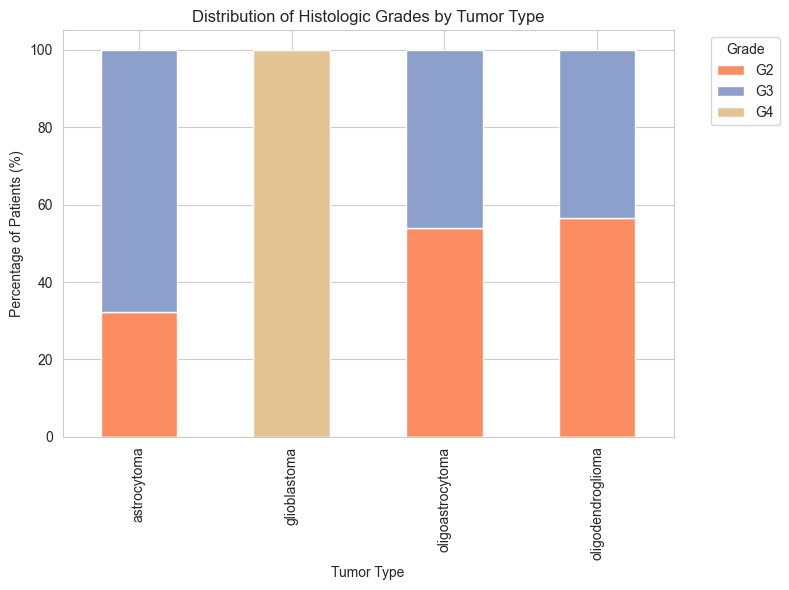

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. One row per patient
df = (
    clinical_mutations_pathways
    [['Patient ID','Neoplasm Histologic Type Name','Neoplasm Histologic Grade']]
    .drop_duplicates('Patient ID')
)

# 2. Compute grade distribution per tumor type (as %)
dist = (
    pd.crosstab(df['Neoplasm Histologic Type Name'],
                df['Neoplasm Histologic Grade'],
                normalize='index')
    * 100
)

# 3. Pick the Set2 colors for orange, blue, pink
full = sns.color_palette("Set2", 8)
# index 1 → orange, 2 → blue, 3 → pink
colors = [full[i] for i in (1, 2, 6)]

# 4. Plot with exactly those three colors
sns.set_style("whitegrid")
ax = dist.plot(
    kind='bar',
    stacked=True,
    color=colors,
    figsize=(8, 6)
)

plt.ylabel('Percentage of Patients (%)')
plt.xlabel('Tumor Type')
plt.title('Distribution of Histologic Grades by Tumor Type')
plt.legend(title='Grade', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


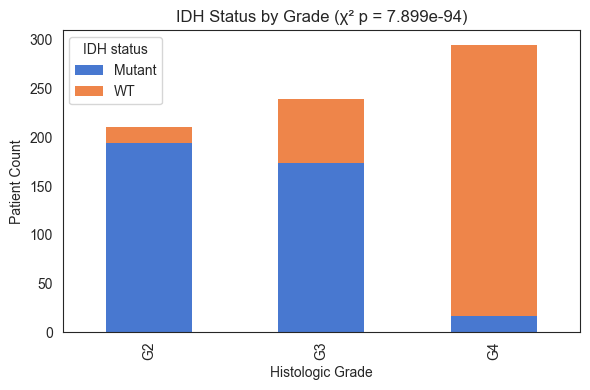

In [206]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# 1. Prepare data
cols = ['Patient ID', 'Neoplasm Histologic Grade', 'IDH status']
clinical_info = (
    clinical_mutations_pathways[cols]
    .drop_duplicates('Patient ID')
)
clinical_info['Grade_Group'] = pd.Categorical(
    clinical_info['Neoplasm Histologic Grade'],
    categories=['G2','G3','G4'],
    ordered=True
)

# 2. Contingency table and χ² test
table = pd.crosstab(clinical_info['Grade_Group'], clinical_info['IDH status'])
chi2, p, _, _ = chi2_contingency(table)

# 3. Plot with muted blue & orange, no grid
sns.set_style("white")
palette = sns.color_palette("muted", n_colors=2)  # muted blue, muted orange

ax = table.plot(
    kind='bar',
    stacked=True,
    color=palette,
    figsize=(6,4),
    edgecolor='none'
)
ax.grid(False)
ax.set_title(f"IDH Status by Grade (χ² p = {p:.3e})")
ax.set_xlabel('Histologic Grade')
ax.set_ylabel('Patient Count')
ax.legend(title='IDH status')
plt.tight_layout()
plt.show()



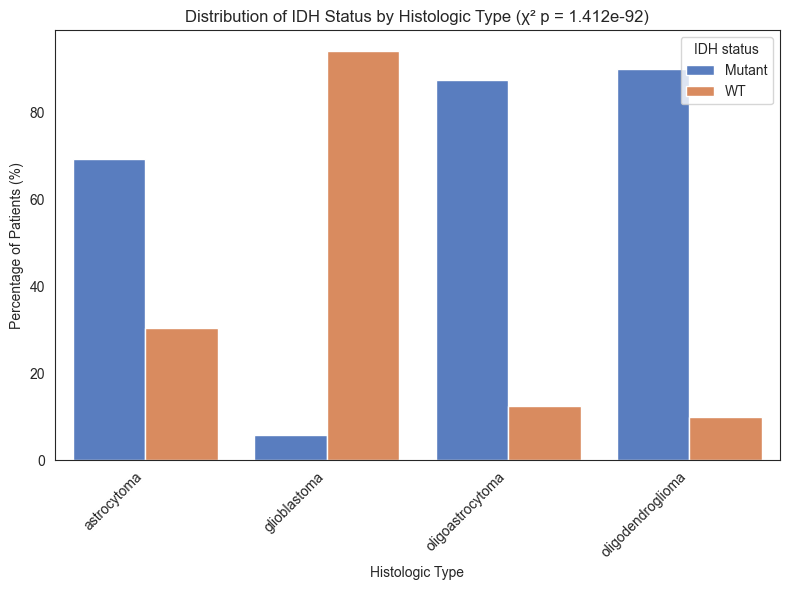

In [209]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# 1. One row per patient
df = (
    clinical_mutations_pathways
    [['Patient ID', 'IDH status', 'Neoplasm Histologic Type Name']]
    .drop_duplicates('Patient ID')
)

# 2. Build contingency table and χ² test
table = pd.crosstab(df['Neoplasm Histologic Type Name'], df['IDH status'])
chi2, p, _, _ = chi2_contingency(table)

# 3. Compute percentages
counts = table.reset_index().melt(id_vars='Neoplasm Histologic Type Name',
                                  var_name='IDH status', value_name='count')
counts['percent'] = (
    counts['count'] /
    counts.groupby('Neoplasm Histologic Type Name')['count'].transform('sum')
    * 100
)

# 4. Plot
sns.set_style("white")
palette = sns.color_palette("muted", 2)  # muted blue & orange

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=counts,
    x='Neoplasm Histologic Type Name',
    y='percent',
    hue='IDH status',
    palette=palette
)
ax.set_ylabel('Percentage of Patients (%)')
ax.set_xlabel('Histologic Type')
ax.set_title(f'Distribution of IDH Status by Histologic Type (χ² p = {p:.3e})')
ax.legend(title='IDH status', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/3653549844.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


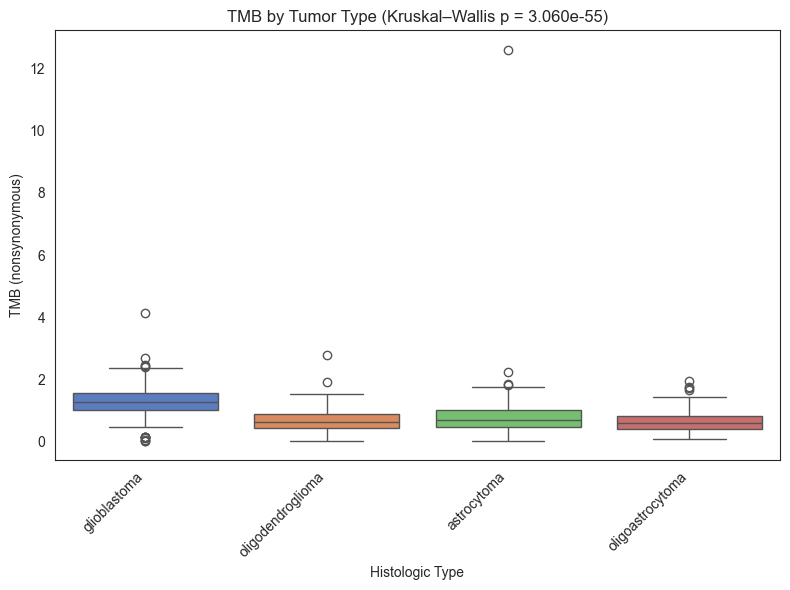

In [210]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# 1. One row per patient with TMB and histologic type
cols = ['Patient ID', 'Neoplasm Histologic Type Name', 'TMB (nonsynonymous)']
df_tmb = clinical_mutations_pathways[cols].drop_duplicates('Patient ID')
df_tmb = df_tmb.dropna(subset=['TMB (nonsynonymous)'])

# 2. Prepare data for Kruskal–Wallis test
types = ['glioblastoma', 'oligodendroglioma', 'astrocytoma', 'oligoastrocytoma']
groups = [df_tmb[df_tmb['Neoplasm Histologic Type Name'] == t]['TMB (nonsynonymous)'] for t in types]
h_stat, p_value = kruskal(*groups)

# 3. Plot
sns.set_style("white")
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=df_tmb,
    x='Neoplasm Histologic Type Name',
    y='TMB (nonsynonymous)',
    order=types,
    palette="muted"
)
ax.set_title(f"TMB by Tumor Type (Kruskal–Wallis p = {p_value:.3e})")
ax.set_xlabel('Histologic Type')
ax.set_ylabel('TMB (nonsynonymous)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/1323305948.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


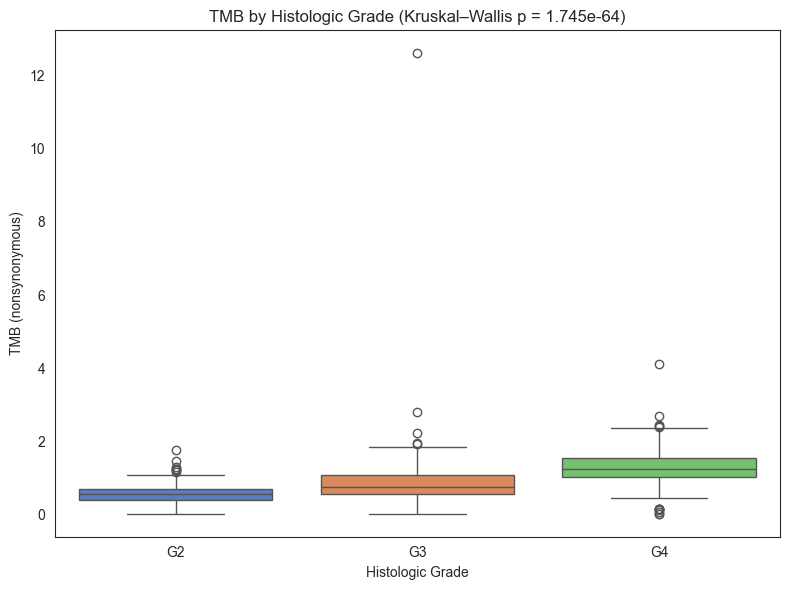

In [211]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# 1. One row per patient with TMB and grade
cols = ['Patient ID', 'Neoplasm Histologic Grade', 'TMB (nonsynonymous)']
df_tmb = clinical_mutations_pathways[cols].drop_duplicates('Patient ID')
df_tmb = df_tmb.dropna(subset=['TMB (nonsynonymous)'])

# 2. Prepare grade-ordered categories
grade_order = ['G2', 'G3', 'G4']
df_tmb['Grade'] = pd.Categorical(
    df_tmb['Neoplasm Histologic Grade'],
    categories=grade_order,
    ordered=True
)

# 3. Kruskal–Wallis test across grades
groups = [df_tmb[df_tmb['Grade'] == g]['TMB (nonsynonymous)'] for g in grade_order]
h_stat, p_value = kruskal(*groups)

# 4. Plot
sns.set_style("white")
plt.figure(figsize=(8,6))
ax = sns.boxplot(
    data=df_tmb,
    x='Grade',
    y='TMB (nonsynonymous)',
    order=grade_order,
    palette="muted"
)
ax.set_title(f"TMB by Histologic Grade (Kruskal–Wallis p = {p_value:.3e})")
ax.set_xlabel('Histologic Grade')
ax.set_ylabel('TMB (nonsynonymous)')
ax.grid(False)
plt.tight_layout()
plt.show()


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/2943769194.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


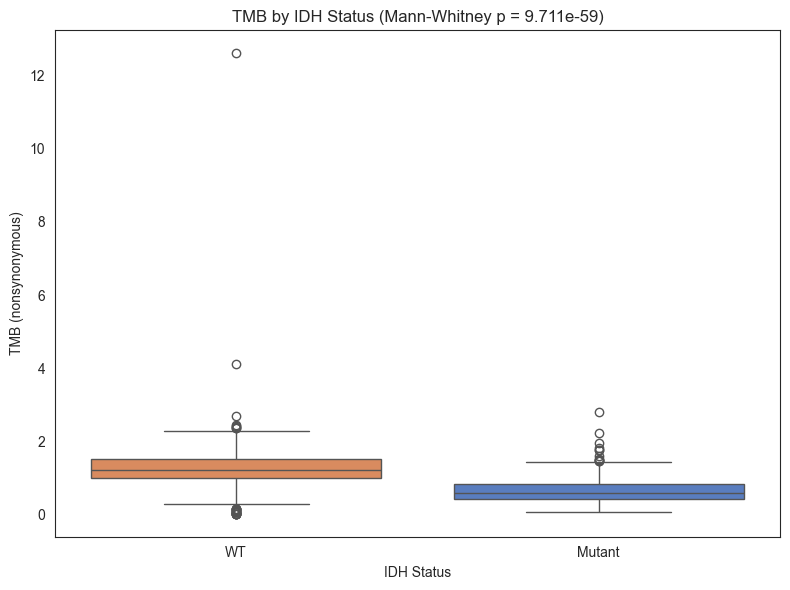

In [214]:
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare style and muted palette, then reverse it
sns.set_style("white")
base_palette = sns.color_palette("muted", 2)  # [blue, orange]
palette = [base_palette[1], base_palette[0]]  # now [orange, blue]

# 2. Get one row per patient with necessary columns
cols_needed = ['Patient ID', 'IDH status', 'TMB (nonsynonymous)']
clinical_info = clinical_mutations_pathways[cols_needed].drop_duplicates('Patient ID')

# 3. Drop NaNs in TMB
clinical_info = clinical_info.dropna(subset=['TMB (nonsynonymous)'])

# 4. Mann-Whitney U test
mutant = clinical_info.loc[clinical_info['IDH status'] == 'Mutant', 'TMB (nonsynonymous)']
wt     = clinical_info.loc[clinical_info['IDH status'] == 'WT',     'TMB (nonsynonymous)']
_, p_value = mannwhitneyu(mutant, wt, alternative='two-sided')

# 5. Plot with reversed colors
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=clinical_info,
    x='IDH status',
    y='TMB (nonsynonymous)',
    palette=palette
)
plt.title(f"TMB by IDH Status (Mann-Whitney p = {p_value:.3e})")
plt.xlabel('IDH Status')
plt.ylabel('TMB (nonsynonymous)')
plt.tight_layout()
plt.show()


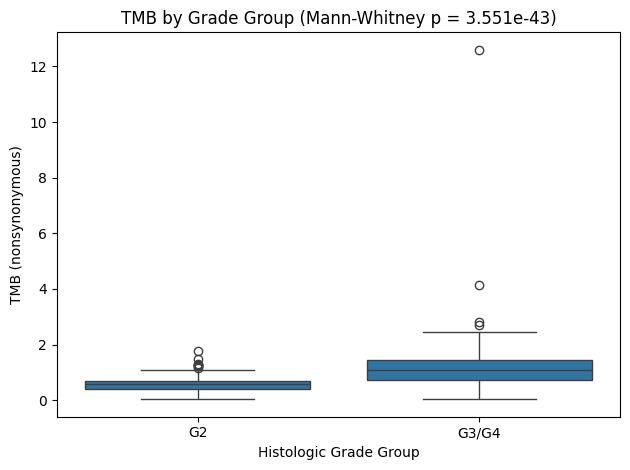

In [147]:
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns and deduplicate
cols = ['Patient ID', 'Neoplasm Histologic Grade', 'TMB (nonsynonymous)']
df = clinical_mutations_pathways[cols].drop_duplicates('Patient ID')

# Group grades
df['Grade_Group'] = df['Neoplasm Histologic Grade'].replace({'G2': 'G2', 'G3': 'G3/G4', 'G4': 'G3/G4'})
df['Grade_Group'] = pd.Categorical(df['Grade_Group'], categories=['G2', 'G3/G4'], ordered=True)

# Drop NaNs
df = df.dropna(subset=['TMB (nonsynonymous)'])

# Split groups
g2 = df[df['Grade_Group'] == 'G2']['TMB (nonsynonymous)']
g34 = df[df['Grade_Group'] == 'G3/G4']['TMB (nonsynonymous)']

# Mann-Whitney U test
_, p = mannwhitneyu(g2, g34, alternative='two-sided')

# Plot
sns.boxplot(data=df, x='Grade_Group', y='TMB (nonsynonymous)')
plt.title(f"TMB by Grade Group (Mann-Whitney p = {p:.3e})")
plt.xlabel('Histologic Grade Group')
plt.ylabel('TMB (nonsynonymous)')
plt.tight_layout()
plt.show()


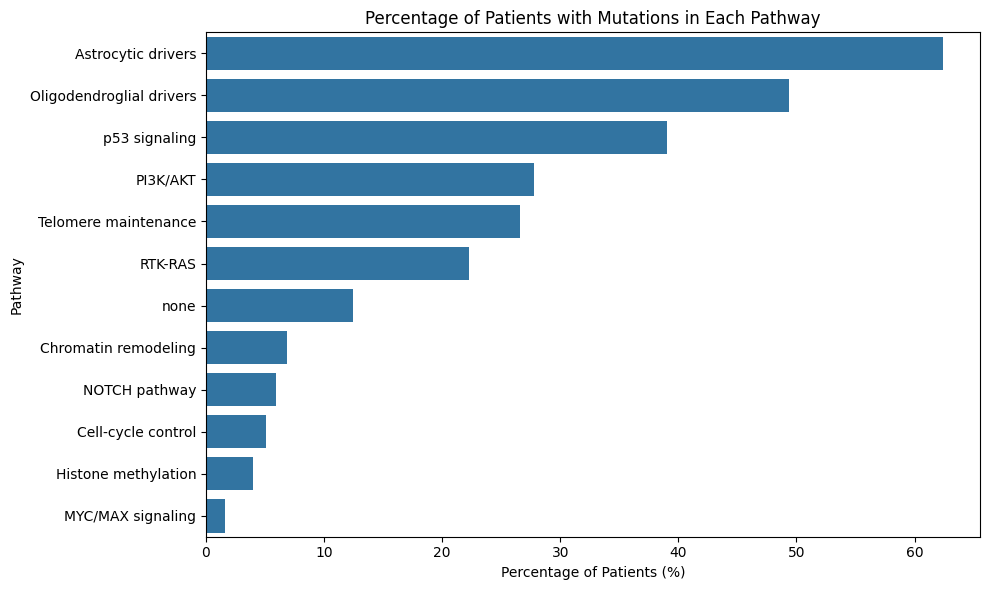

In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Unique Patient–Pathway pairs
df_pp = clinical_mutations_pathways[['Patient ID','Pathway']].drop_duplicates()

# 2. Figure out patients whose only pathway is 'none'
all_pats       = set(df_pp['Patient ID'])
p_with_real    = set(df_pp.loc[df_pp['Pathway']!='none','Patient ID'])
only_none      = all_pats - p_with_real

# 3. Count patients per non-none pathway
counts = (
    df_pp[df_pp['Pathway']!='none']
      .groupby('Pathway')['Patient ID']
      .nunique()
)

# 4. Add the true 'none' count
counts['none'] = len(only_none)

# 5. Compute percentages
total = len(all_pats)
percent = (counts / total * 100).sort_values(ascending=False)

# 6. Plot
plt.figure(figsize=(10,6))
sns.barplot(x=percent.values, y=percent.index)
plt.xlabel('Percentage of Patients (%)')
plt.ylabel('Pathway')
plt.title('Percentage of Patients with Mutations in Each Pathway')
plt.tight_layout()
plt.show()


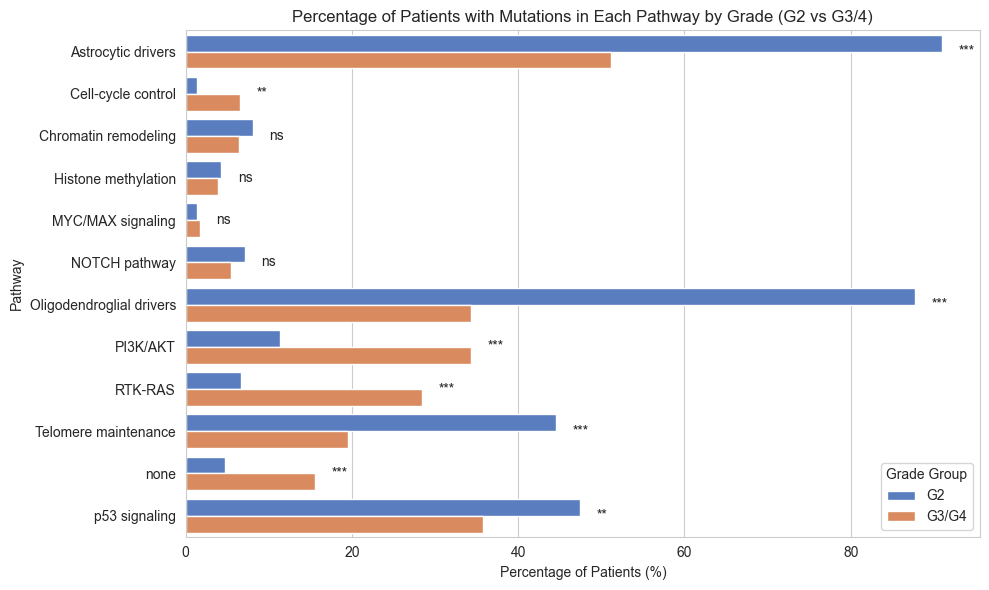

In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

# 1. Unique Patient–Pathway pairs
df_pp = clinical_mutations_pathways[['Patient ID','Pathway']].drop_duplicates()

# 2. Add Grade_Group
patient_grade = clinical_mutations_pathways[['Patient ID','Neoplasm Histologic Grade']].drop_duplicates()
patient_grade['Grade_Group'] = patient_grade['Neoplasm Histologic Grade'].replace({
    'G2':'G2','G3':'G3/G4','G4':'G3/G4'
})
df_pp = df_pp.merge(patient_grade[['Patient ID','Grade_Group']], on='Patient ID')

# 3. Total patients per grade
grade_totals = (
    df_pp.drop_duplicates(['Patient ID','Grade_Group'])
         .groupby('Grade_Group')['Patient ID']
         .nunique()
)

# 4. Counts per pathway × grade
counts = (
    df_pp.groupby(['Pathway','Grade_Group'])['Patient ID']
         .nunique()
         .unstack(fill_value=0)
)

# 5. Fix 'none' to count only those with no real-pathway mutations
all_pats    = set(df_pp['Patient ID'])
p_with_real = set(df_pp[df_pp['Pathway']!='none']['Patient ID'])
only_none   = all_pats - p_with_real

# map each patient to its grade
grade_map = dict(zip(patient_grade['Patient ID'], patient_grade['Grade_Group']))
none_counts = {'G2':0, 'G3/G4':0}
for p in only_none:
    gr = grade_map[p]
    none_counts[gr] += 1

counts.loc['none','G2']    = none_counts['G2']
counts.loc['none','G3/G4'] = none_counts['G3/G4']

# 6. Compute percentages
percent = counts.div(grade_totals, axis=1) * 100

# 7. Fisher's exact p-values
p_values = {}
for pw in counts.index:
    a = counts.loc[pw,'G2']
    b = grade_totals['G2'] - a
    c = counts.loc[pw,'G3/G4']
    d = grade_totals['G3/G4'] - c
    _, p = fisher_exact([[a,b],[c,d]])
    p_values[pw] = p

# 8. Prepare long-format DataFrame
plot_df = (
    percent
    .rename_axis('Pathway')
    .reset_index()
    .melt(id_vars='Pathway', var_name='Grade', value_name='Percentage')
)

# 9. Plot
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.barplot(data=plot_df, x='Percentage', y='Pathway', hue='Grade', palette='muted')

# annotate significance
for i, pw in enumerate(percent.index):
    x = percent.loc[pw].max() + 2
    p = p_values[pw]
    star = '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else 'ns'
    ax.text(x, i, star, va='center')

ax.set_title('Percentage of Patients with Mutations in Each Pathway by Grade (G2 vs G3/4)')
ax.set_xlabel('Percentage of Patients (%)')
ax.set_ylabel('Pathway')
ax.legend(title='Grade Group')
plt.tight_layout()
plt.show()


s the distribution of patients with versus without that pathway mutation different across the four histologic types?”

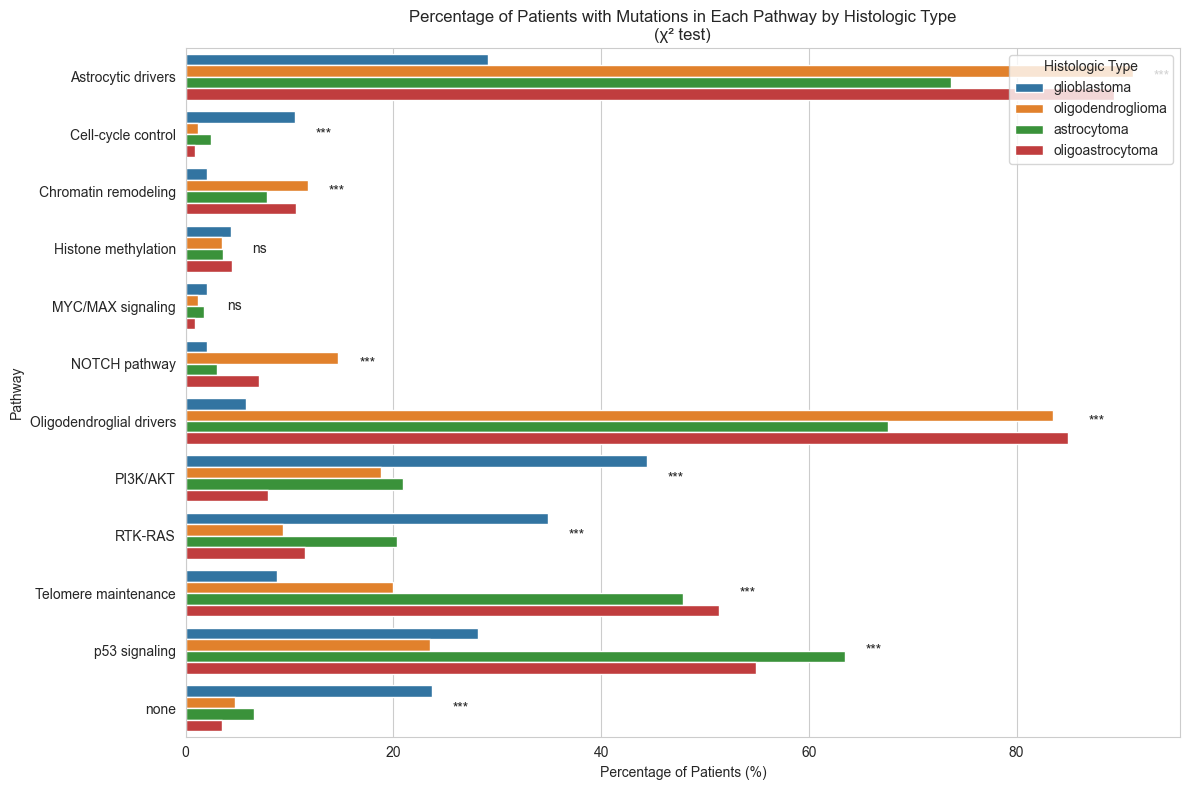

In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# 1. Unique Patient–Pathway pairs
df_pp = clinical_mutations_pathways[['Patient ID','Pathway']].drop_duplicates()

# 2. Attach histologic type
patient_type = clinical_mutations_pathways[['Patient ID','Neoplasm Histologic Type Name']] \
    .drop_duplicates()
df_pp = df_pp.merge(patient_type, on='Patient ID')

# 3. Identify patients with only 'none'
all_pats    = set(df_pp['Patient ID'])
p_with_real = set(df_pp.loc[df_pp['Pathway']!='none','Patient ID'])
only_none   = all_pats - p_with_real

# 4. Count per pathway × type (excluding 'none'), then add 'none'
types = ['glioblastoma','oligodendroglioma','astrocytoma','oligoastrocytoma']
counts = (df_pp[df_pp['Pathway']!='none']
          .groupby(['Pathway','Neoplasm Histologic Type Name'])['Patient ID']
          .nunique()
          .unstack(fill_value=0)
          .reindex(columns=types, fill_value=0))
none_counts = {
    t: len({
        p for p in only_none
        if patient_type.set_index('Patient ID').loc[p,'Neoplasm Histologic Type Name']==t
    }) for t in types
}
counts.loc['none', types] = pd.Series(none_counts)

# 5. Totals and percentages
totals = patient_type['Neoplasm Histologic Type Name'].value_counts().reindex(types)
percent = counts.div(totals, axis=1) * 100

# 6. Chi-squared test per pathway
p_values = {}
for pw in counts.index:
    mutated = counts.loc[pw, types].values
    not_mut = (totals.values - mutated)
    chi2, p, _, _ = chi2_contingency([mutated, not_mut])
    p_values[pw] = p

# 7. Melt for plotting
plot_df = (percent
           .rename_axis('Pathway')
           .reset_index()
           .melt(id_vars='Pathway',
                 var_name='Type',
                 value_name='Percentage'))

# 8. Plot with annotation
sns.set_style("whitegrid")
plt.figure(figsize=(12,8))
ax = sns.barplot(data=plot_df, x='Percentage', y='Pathway', hue='Type', order=percent.index, hue_order=types)

# annotate p-values
for i, pw in enumerate(percent.index):
    p = p_values[pw]
    star = '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else 'ns'
    x = percent.loc[pw].max() + 2
    ax.text(x, i, star, va='center')

ax.set_xlabel('Percentage of Patients (%)')
ax.set_ylabel('Pathway')
ax.set_title('Percentage of Patients with Mutations in Each Pathway by Histologic Type\n(χ² test)')
ax.legend(title='Histologic Type', loc='upper right')
plt.tight_layout()
plt.show()


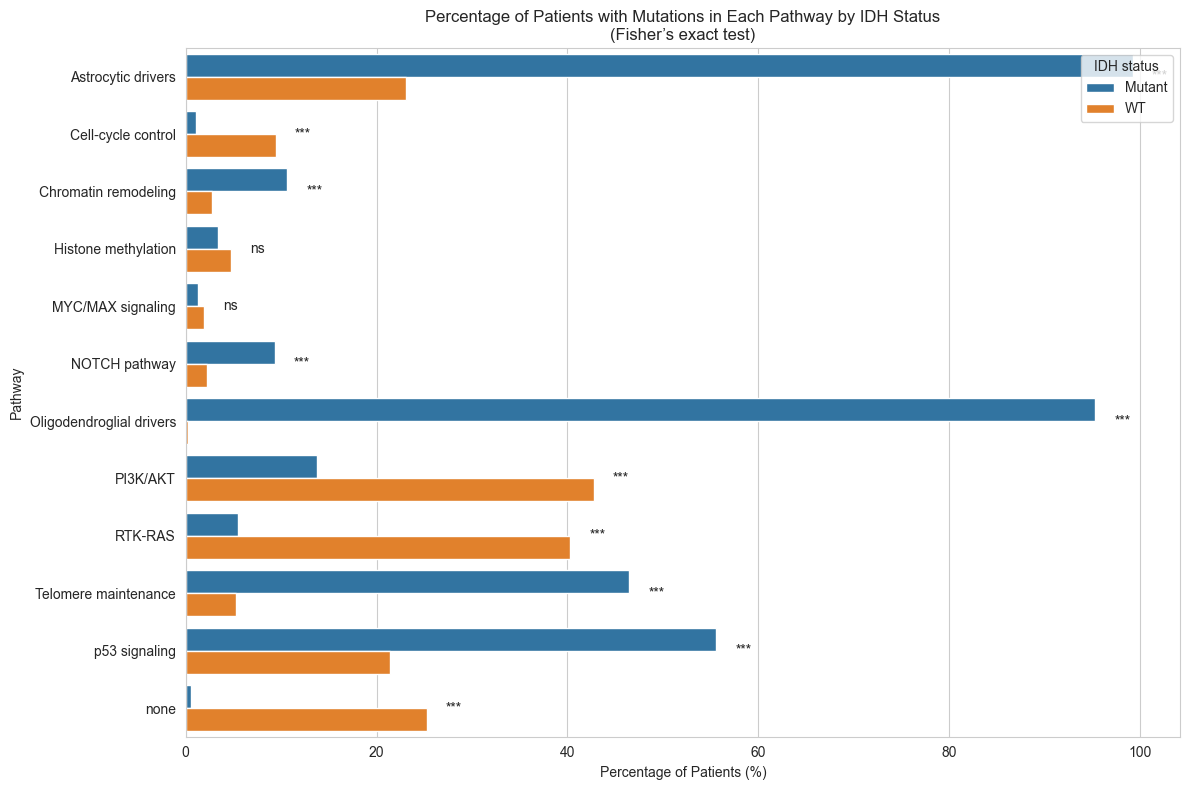

In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

# 1. Unique Patient–Pathway–IDH status rows
df_pp = clinical_mutations_pathways[['Patient ID','Pathway','IDH status']].drop_duplicates()

# 2. Identify patients with only 'none'
all_pats    = set(df_pp['Patient ID'])
p_with_real = set(df_pp[df_pp['Pathway']!='none']['Patient ID'])
only_none   = all_pats - p_with_real

# 3. Count patients per pathway × IDH status (excluding 'none')
statuses = ['Mutant','WT']
counts = (
    df_pp[df_pp['Pathway']!='none']
      .groupby(['Pathway','IDH status'])['Patient ID']
      .nunique()
      .unstack(fill_value=0)
      .reindex(columns=statuses, fill_value=0)
)

# 4. Add true 'none' counts split by IDH status
none_counts = {
    s: len({
        p for p in only_none
        if df_pp.loc[df_pp['Patient ID']==p, 'IDH status'].iloc[0] == s
    })
    for s in statuses
}
counts.loc['none', statuses] = pd.Series(none_counts)

# 5. Compute percentages
totals = (
    df_pp.drop_duplicates(['Patient ID','IDH status'])
         .groupby('IDH status')['Patient ID']
         .nunique()
         .reindex(statuses)
)
percent = counts.div(totals, axis=1) * 100

# 6. Fisher’s exact test per pathway
p_values = {}
for pw in counts.index:
    a = counts.loc[pw, 'Mutant']
    b = totals['Mutant'] - a
    c = counts.loc[pw,   'WT']
    d = totals['WT'] - c
    _, p = fisher_exact([[a, b], [c, d]])
    p_values[pw] = p

# 7. Melt for plotting
plot_df = (
    percent
    .rename_axis('Pathway')
    .reset_index()
    .melt(id_vars='Pathway', var_name='IDH status', value_name='Percentage')
)

# 8. Plot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=plot_df,
    x='Percentage',
    y='Pathway',
    hue='IDH status',
    order=percent.index
)

# annotate significance
for i, pw in enumerate(percent.index):
    p = p_values[pw]
    star = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    x = percent.loc[pw].max() + 2
    ax.text(x, i, star, va='center')

ax.set_xlabel('Percentage of Patients (%)')
ax.set_ylabel('Pathway')
ax.set_title('Percentage of Patients with Mutations in Each Pathway by IDH Status\n(Fisher’s exact test)')
ax.legend(title='IDH status', loc='upper right')
plt.tight_layout()
plt.show()


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/4043293415.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Pathway','Grade_Group'])['Patient ID']
/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/4043293415.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Grade_Group')['Patient ID'] \


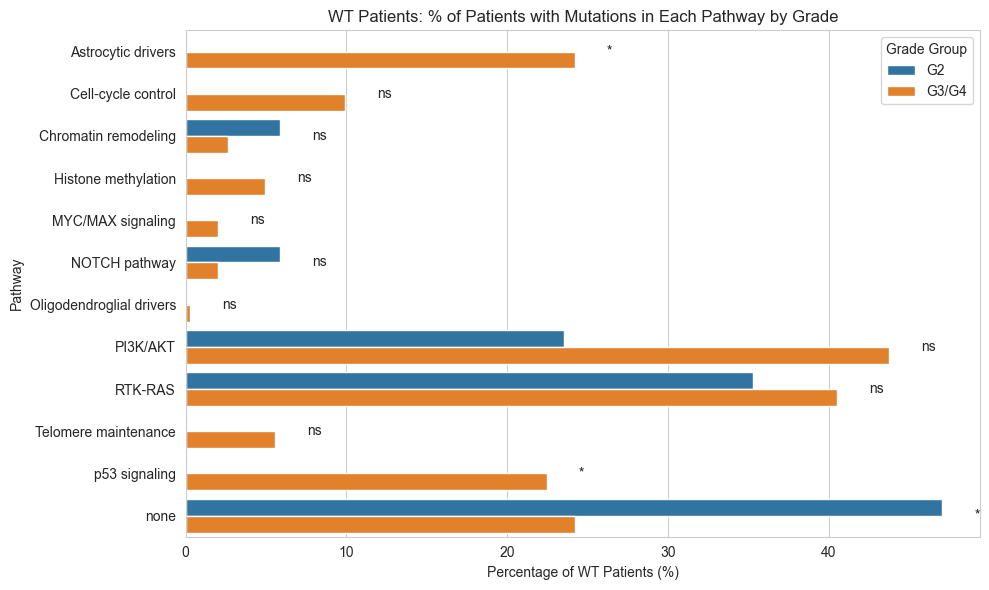

In [166]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

# 1. Subset to IDH WT patients
wt_df = clinical_mutations_pathways[clinical_mutations_pathways['IDH status'] == 'WT']

# 2. Unique Patient–Pathway–Grade rows
df_pp = wt_df[['Patient ID','Pathway','Neoplasm Histologic Grade']].drop_duplicates()

# 3. Map grades to G2 vs G3/G4
df_pp['Grade_Group'] = df_pp['Neoplasm Histologic Grade'] \
    .replace({'G2':'G2','G3':'G3/G4','G4':'G3/G4'})
df_pp['Grade_Group'] = pd.Categorical(df_pp['Grade_Group'],
                                      categories=['G2','G3/G4'],
                                      ordered=True)

# 4. Identify WT patients with only 'none'
all_wt = set(df_pp['Patient ID'])
with_real = set(df_pp[df_pp['Pathway']!='none']['Patient ID'])
only_none = all_wt - with_real

# 5. Count per pathway × grade (excluding 'none')
counts = (
    df_pp[df_pp['Pathway']!='none']
      .groupby(['Pathway','Grade_Group'])['Patient ID']
      .nunique()
      .unstack(fill_value=0)
)

# 6. Add true 'none' counts per grade group
none_counts = {'G2':0,'G3/G4':0}
for pid in only_none:
    g = df_pp.loc[df_pp['Patient ID']==pid,'Grade_Group'].iloc[0]
    none_counts[g] += 1

counts.loc['none','G2']    = none_counts['G2']
counts.loc['none','G3/G4'] = none_counts['G3/G4']

# 7. Compute total WT patients per grade and percentages
grade_totals = df_pp.drop_duplicates(['Patient ID','Grade_Group']) \
                   .groupby('Grade_Group')['Patient ID'] \
                   .nunique()
percent = counts.div(grade_totals, axis=1) * 100

# 8. Fisher’s exact test per pathway
p_values = {}
for pw in counts.index:
    a = counts.loc[pw,'G2']
    b = grade_totals['G2'] - a
    c = counts.loc[pw,'G3/G4']
    d = grade_totals['G3/G4'] - c
    _, p = fisher_exact([[a,b],[c,d]])
    p_values[pw] = p

# 9. Melt and plot
plot_df = (percent
           .rename_axis('Pathway')
           .reset_index()
           .melt(id_vars='Pathway', var_name='Grade', value_name='Percentage'))

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=plot_df, x='Percentage', y='Pathway', hue='Grade', order=percent.index)

# annotate significance
for i, pw in enumerate(percent.index):
    p = p_values[pw]
    star = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    x = percent.loc[pw].max() + 2
    ax.text(x, i, star, va='center')

ax.set_title('WT Patients: % of Patients with Mutations in Each Pathway by Grade')
ax.set_xlabel('Percentage of WT Patients (%)')
ax.set_ylabel('Pathway')
ax.legend(title='Grade Group', loc='upper right')
plt.tight_layout()
plt.show()


### **Selecting 20 most frequently mutated genes**

Total number of unique patients: 745
Number of patients without mutations in any of the top 20 genes: 76


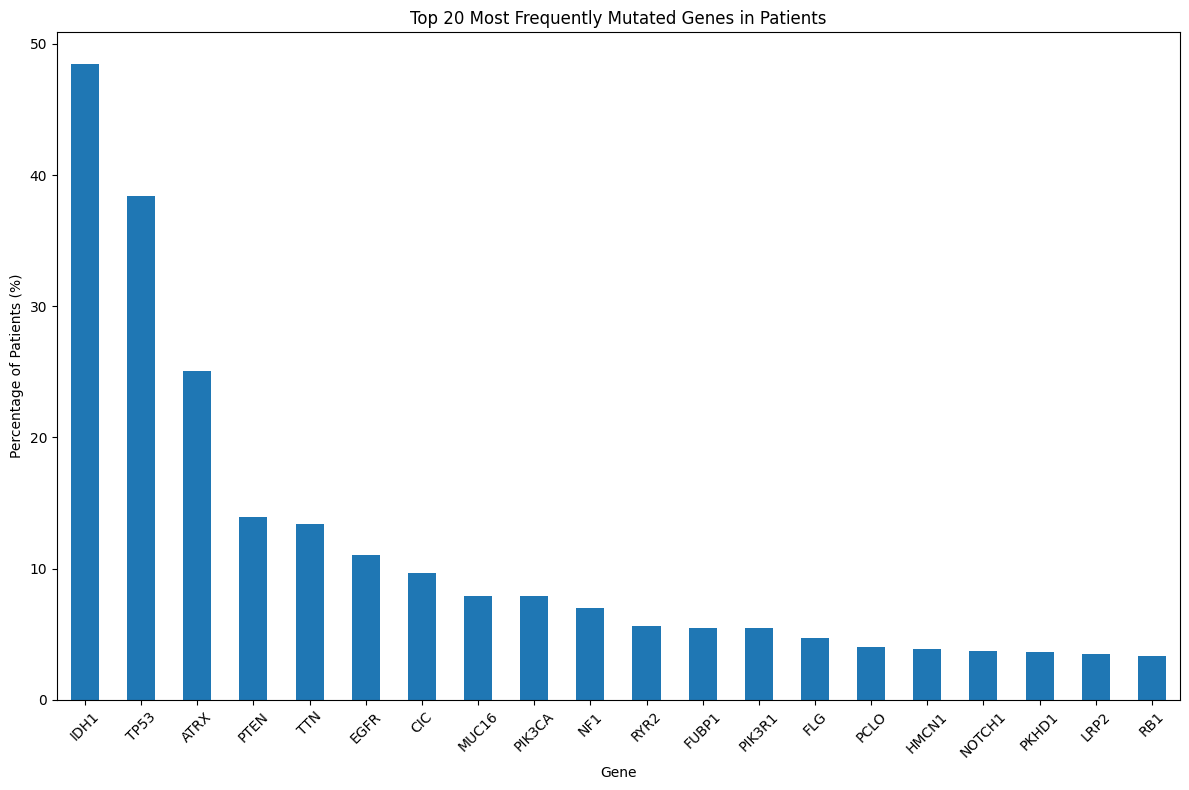

In [55]:
# Step 1: Count unique patients for each gene
gene_patient_counts = mutations_with_pathways.groupby('Hugo_Symbol')['Patient ID'].nunique()

# Step 2: Calculate the percentage of patients with mutations in each gene
total_unique_patients = mutations_with_pathways['Patient ID'].nunique()
gene_patient_percentages = (gene_patient_counts / total_unique_patients) * 100

# Step 3: Select the top 30 most frequently mutated genes
top_20_genes = gene_patient_percentages.nlargest(20).index

# Step 4: Identify unique patients who have mutations in any of the top 20 genes
patients_with_top_20_genes = mutations_with_pathways[mutations_with_pathways['Hugo_Symbol'].isin(top_20_genes)]['Patient ID'].unique()
unique_patients_with_top_20_genes = len(set(patients_with_top_20_genes))

# Step 5: Calculate the number of patients without mutations in any of the top 20 genes
patients_without_top_20_genes = total_unique_patients - unique_patients_with_top_20_genes

# Display results
print(f"Total number of unique patients: {total_unique_patients}")
print(f"Number of patients without mutations in any of the top 20 genes: {patients_without_top_20_genes}")

# Step 6: Plotting the top 20 genes by percentage of patients with mutations
top_20_percentages = gene_patient_percentages[top_20_genes]

plt.figure(figsize=(12, 8))
top_20_percentages.plot(kind='bar')
plt.xlabel("Gene")
plt.ylabel("Percentage of Patients (%)")
plt.title("Top 20 Most Frequently Mutated Genes in Patients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [72]:
# Step 1: Filter for patients with IDH1 or IDH2 mutations (group 1: IDH mutant)
idh_mutant = mutations_with_pathways[mutations_with_pathways['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]

# Step 2: Get unique Patient IDs for IDH mutants
idh_mutant_patients = idh_mutant['Patient ID'].unique()

# Step 3: Identify IDH WT (wild-type) patients (group 2: not IDH1 or IDH2)
idh_wt = mutations_with_pathways[~mutations_with_pathways['Patient ID'].isin(idh_mutant_patients)]

# Step 4: Count the number of unique Patient IDs in each group
idh_mutant_count = len(idh_mutant_patients)
idh_wt_count = len(idh_wt['Patient ID'].unique())

# Step 5: Print the results
print(f"Number of IDH mutant patients: {idh_mutant_count}")
print(f"Number of IDH WT patients: {idh_wt_count}")

Number of IDH mutant patients: 379
Number of IDH WT patients: 366


We chose top 20 genes as features, now we are going to chose 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'Pan-Glioma DNA Methylation Cluster', 'Neoplasm Histologic Type Name', 'Neoplasm Histologic Grade' for clustering analysis

In [ ]:
# Filter mutations_with_pathways to include only rows with the top 20 genes, while retaining all patients
top_20_mutations_df = mutations_with_pathways[mutations_with_pathways['Hugo_Symbol'].isin(top_20_genes)]
all_patients_df = mutations_with_pathways[['Patient ID']].drop_duplicates()
top_20_encoded_df = all_patients_df.merge(top_20_mutations_df, on='Patient ID', how='left')

# One-hot encode the presence of each of the top 20 genes for all patients
for gene in top_20_genes:
    top_20_encoded_df[gene] = (top_20_encoded_df['Hugo_Symbol'] == gene).astype(int)

# Remove columns not needed for analysis
top_20_encoded_df = top_20_encoded_df.drop(columns=['Hugo_Symbol', 'Variant_Classification', 'Tumor_Sample_Barcode'])

# Display the resulting DataFrame for verification
print("Top 20 one-hot encoded DataFrame with all patients retained:")
print(top_20_encoded_df.head())

Top 20 one-hot encoded DataFrame with all patients retained:
     Patient ID        Sample ID             Pathway  IDH1  TP53  ATRX  PTEN  \
0  TCGA-02-0003  TCGA-02-0003-01             RTK-RAS     0     0     0     0   
1  TCGA-02-0003  TCGA-02-0003-01            PI3K/AKT     0     0     0     0   
2  TCGA-02-0003  TCGA-02-0003-01  Astrocytic drivers     0     1     0     0   
3  TCGA-02-0003  TCGA-02-0003-01       p53 signaling     0     1     0     0   
4  TCGA-02-0003  TCGA-02-0003-01  Astrocytic drivers     0     1     0     0   

   TTN  EGFR  CIC  ...  RYR2  FUBP1  PIK3R1  FLG  PCLO  HMCN1  NOTCH1  PKHD1  \
0    0     1    0  ...     0      0       0    0     0      0       0      0   
1    0     0    0  ...     0      0       1    0     0      0       0      0   
2    0     0    0  ...     0      0       0    0     0      0       0      0   
3    0     0    0  ...     0      0       0    0     0      0       0      0   
4    0     0    0  ...     0      0       0    0     0    

In [47]:
# Save the cleaned DataFrame
top_20_encoded_df.to_csv('top_20_encoded_df.csv', index=False)

In [57]:
# Select relevant columns from clinical_data
clinical_columns = ['Patient ID', 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'Pan-Glioma DNA Methylation Cluster', 'Neoplasm Histologic Type Name', 'Neoplasm Histologic Grade']
clinical_selected = clinical_data[clinical_columns]

# Merge the selected clinical columns with top_20_encoded_df on 'Patient ID'
merged_top_20_df = pd.merge(top_20_encoded_df, clinical_selected, on='Patient ID', how='left')

# Display the resulting DataFrame for verification
print("Merged DataFrame with top 20 encoded genes and selected clinical data:")
print(merged_top_20_df.head())

Merged DataFrame with top 20 encoded genes and selected clinical data:
     Patient ID        Sample ID             Pathway  IDH1  TP53  ATRX  PTEN  \
0  TCGA-02-0003  TCGA-02-0003-01             RTK-RAS     0     0     0     0   
1  TCGA-02-0003  TCGA-02-0003-01            PI3K/AKT     0     0     0     0   
2  TCGA-02-0003  TCGA-02-0003-01  Astrocytic drivers     0     1     0     0   
3  TCGA-02-0003  TCGA-02-0003-01       p53 signaling     0     1     0     0   
4  TCGA-02-0003  TCGA-02-0003-01  Astrocytic drivers     0     1     0     0   

   TTN  EGFR  CIC  ...  NOTCH1  PKHD1  LRP2  RB1  Diagnosis Age   Sex  \
0    0     1    0  ...       0      0     0    0             50  Male   
1    0     0    0  ...       0      0     0    0             50  Male   
2    0     0    0  ...       0      0     0    0             50  Male   
3    0     0    0  ...       0      0     0    0             50  Male   
4    0     0    0  ...       0      0     0    0             50  Male   

   TMB (n

In [58]:
# Df to go back to after clustering
merged_before_norm_df = merged_top_20_df.copy()

Check NaN values in the dataset

In [59]:
# Group by 'Patient ID' to get unique patient entries
unique_patients_df = merged_before_norm_df.groupby('Patient ID').first()

# Count NaNs in each column
nan_counts = unique_patients_df.isnull().sum()
print("Count of NaNs in each column:")
print(nan_counts)

# Display the unique patient count after grouping
total_unique_patients = unique_patients_df.shape[0]
print(f"\nTotal Unique Patient Count: {total_unique_patients}")

# Check unique counts in 'Sex' after grouping
sex_distribution = unique_patients_df['Sex'].value_counts()
print("\nSex Distribution:")
print(sex_distribution)


Count of NaNs in each column:
Sample ID                             76
Pathway                               76
IDH1                                   0
TP53                                   0
ATRX                                   0
PTEN                                   0
TTN                                    0
EGFR                                   0
CIC                                    0
MUC16                                  0
PIK3CA                                 0
NF1                                    0
RYR2                                   0
FUBP1                                  0
PIK3R1                                 0
FLG                                    0
PCLO                                   0
HMCN1                                  0
NOTCH1                                 0
PKHD1                                  0
LRP2                                   0
RB1                                    0
Diagnosis Age                          0
Sex                        

### **Descriptive stats on the dataset after dropping NaN**

Total Unique Patient Count: 696

Sex Distribution:
Sex
Male      405
Female    291
Name: count, dtype: int64

Age Distribution Statistics:
count    696.000000
mean      49.573276
std       15.909649
min       14.000000
25%       36.000000
50%       50.000000
75%       62.000000
max       89.000000
Name: Diagnosis Age, dtype: float64

Neoplasm Histologic Type Distribution:
Neoplasm Histologic Type Name
glioblastoma         246
oligodendroglioma    170
astrocytoma          167
oligoastrocytoma     113
Name: count, dtype: int64

Neoplasm Histologic Grade Distribution:
Neoplasm Histologic Grade
G4    246
G3    239
G2    211
Name: count, dtype: int64


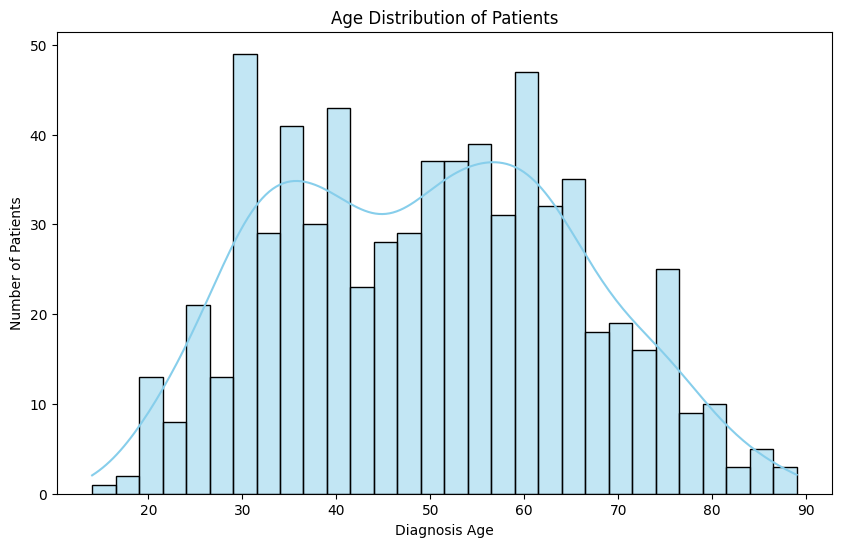

In [60]:
# Drop 'Sample ID' column and rows with NaNs in 'Pan-Glioma DNA Methylation Cluster'
cleaned_df = merged_before_norm_df.drop(columns=['Sample ID']).dropna(subset=['Pan-Glioma DNA Methylation Cluster'])

# Group by 'Patient ID' to get unique patient entries and setting Patient ID as index (use reset_index() to reverse when needed)
unique_patients_df = cleaned_df.groupby('Patient ID').first()

# Total unique patient count
total_unique_patients = unique_patients_df.shape[0]
print(f"Total Unique Patient Count: {total_unique_patients}")

# Sex distribution
sex_distribution = unique_patients_df['Sex'].value_counts()
print("\nSex Distribution:")
print(sex_distribution)

# Age distribution
print("\nAge Distribution Statistics:")
print(unique_patients_df['Diagnosis Age'].describe())

# Neoplasm Histologic Type distribution
neoplasm_type_distribution = unique_patients_df['Neoplasm Histologic Type Name'].value_counts()
print("\nNeoplasm Histologic Type Distribution:")
print(neoplasm_type_distribution)

# Neoplasm Histologic Grade distribution
neoplasm_grade_distribution = unique_patients_df['Neoplasm Histologic Grade'].value_counts()
print("\nNeoplasm Histologic Grade Distribution:")
print(neoplasm_grade_distribution)

# Plot the age distribution
plt.figure(figsize=(10, 6))
sns.histplot(unique_patients_df['Diagnosis Age'], kde=True, bins=30, color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Diagnosis Age')
plt.ylabel('Number of Patients')
plt.show()

One-hot encoding other features

In [61]:
# One-hot encode the Neoplasm Histologic Grade column with 0/1 encoding
encoded_grades_df = pd.get_dummies(unique_patients_df['Neoplasm Histologic Grade'], prefix='Grade').astype(int)

# Concatenate the encoded grades back to the main DataFrame
unique_patients_df = pd.concat([unique_patients_df, encoded_grades_df], axis=1)

# Drop the original Neoplasm Histologic Grade column as it is no longer needed
unique_patients_df = unique_patients_df.drop(columns=['Neoplasm Histologic Grade'])

# Encode Sex: 1 for 'Male', 0 for 'Female'
unique_patients_df['Sex'] = unique_patients_df['Sex'].map({'Male': 1, 'Female': 0}).astype(int)

# One-hot encode the Pan-Glioma DNA Methylation Cluster with 0/1 encoding
encoded_grades_df = pd.get_dummies(unique_patients_df['Pan-Glioma DNA Methylation Cluster'], prefix='Meth').astype(int)

# Concatenate the encoded grades back to the main DataFrame
unique_patients_df = pd.concat([unique_patients_df, encoded_grades_df], axis=1)

# Drop the original Pan-Glioma DNA Methylation Cluster column as it is no longer needed
unique_patients_df = unique_patients_df.drop(columns=['Pan-Glioma DNA Methylation Cluster'])

# One-hot encode the Pathway column with 0/1 encoding
encoded_pathways_df = pd.get_dummies(unique_patients_df['Pathway'], prefix='Pathway').astype(int)

# Concatenate the encoded pathways back to the main DataFrame
unique_patients_df = pd.concat([unique_patients_df, encoded_pathways_df], axis=1)

# Drop the original Pathway column as it is no longer needed
unique_patients_df = unique_patients_df.drop(columns=['Pathway'])

# Display the counts for each unique variable in the 'Neoplasm Histologic Type Name' column
type_counts = unique_patients_df['Neoplasm Histologic Type Name'].value_counts()

# Print the counts
print("Counts for each Neoplasm Histologic Type:")
print(type_counts)

# Ensure one-hot encoding columns are integers (1/0)
unique_patients_df = pd.concat([unique_patients_df, pd.get_dummies(unique_patients_df['Neoplasm Histologic Type Name'], prefix='Type').astype(int)], axis=1)

# Display the first few rows to verify
print("DataFrame with one-hot encoding:")
print(unique_patients_df.head())


Counts for each Neoplasm Histologic Type:
Neoplasm Histologic Type Name
glioblastoma         246
oligodendroglioma    170
astrocytoma          167
oligoastrocytoma     113
Name: count, dtype: int64
DataFrame with one-hot encoding:
              IDH1  TP53  ATRX  PTEN  TTN  EGFR  CIC  MUC16  PIK3CA  NF1  ...  \
Patient ID                                                                ...   
TCGA-02-0003     0     0     0     0    0     1    0      0       0    0  ...   
TCGA-02-0033     0     0     0     0    0     0    0      0       0    1  ...   
TCGA-02-0047     0     0     0     0    0     0    0      0       1    0  ...   
TCGA-02-0055     0     0     0     1    0     0    0      0       0    0  ...   
TCGA-02-2470     0     0     0     1    0     0    0      0       0    0  ...   

              Pathway_Cell-cycle control  Pathway_NOTCH pathway  \
Patient ID                                                        
TCGA-02-0003                           0                      0   


Normalisation of numerical values

In [62]:
# Drop 'Neoplasm Histologic Type Name'
unique_patients_df = unique_patients_df.drop(columns=['Neoplasm Histologic Type Name'])

# Initialize the scaler
scaler = MinMaxScaler()

# Save the result into a new DataFrame
normalized_df = unique_patients_df.copy()

# Normalize 'Diagnosis Age' and 'TMB (nonsynonymous)' columns
normalized_df[['Diagnosis Age', 'TMB (nonsynonymous)']] = scaler.fit_transform(
    normalized_df[['Diagnosis Age', 'TMB (nonsynonymous)']]
)

# Display the resulting DataFrame for verification
print("Normalized DataFrame with Diagnosis Age and TMB (nonsynonymous):")
print(normalized_df.head())

Normalized DataFrame with Diagnosis Age and TMB (nonsynonymous):
              IDH1  TP53  ATRX  PTEN  TTN  EGFR  CIC  MUC16  PIK3CA  NF1  ...  \
Patient ID                                                                ...   
TCGA-02-0003     0     0     0     0    0     1    0      0       0    0  ...   
TCGA-02-0033     0     0     0     0    0     0    0      0       0    1  ...   
TCGA-02-0047     0     0     0     0    0     0    0      0       1    0  ...   
TCGA-02-0055     0     0     0     1    0     0    0      0       0    0  ...   
TCGA-02-2470     0     0     0     1    0     0    0      0       0    0  ...   

              Pathway_Cell-cycle control  Pathway_NOTCH pathway  \
Patient ID                                                        
TCGA-02-0003                           0                      0   
TCGA-02-0033                           0                      0   
TCGA-02-0047                           0                      0   
TCGA-02-0055                    